In [1]:
# Copyright 2019 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# Visualization of the YAMNet audio event classification model.
# See https://github.com/tensorflow/models/tree/master/research/audioset/yamnet/
#
# This notebook can be run in Google Colab at https://colab.research.google.com
# by either downloading this ipynb and uploading it, or by looking up the
# notebook directly on GitHub in Colab's "Open notebook" dialog.

In [3]:
# Install required packages.
!pip install soundfile
#!git clone https://github.com/tensorflow/models.git
#%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

!ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  2639k      0  0:00:05  0:00:05 --:--:-- 3532k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   121k      0  0:00:01  0:00:01 --:--:--  121k
total 15300
-rw-r--r-- 1 mike_1102 mike_1102     5174 Dec  1 01:54 README.md
drwxr-xr-x 2 mike_1102 mike_1102     4096 Dec  1 02:00 __pycache__
-rw-r--r-- 1 mike_1102 mike_1102     7705 Dec  1 01:54 export.py
-rw-r--r-- 1 mike_1102 mike_1102     7490 Dec  1 01:54 features.py
-rw-r--r-- 1 mike_1102 mike_1102     2307 Dec  1 01:54 inference.py
-rw-r--r-- 1 mike_1102 mike_1102     1847 Dec  1 01:54 params.py
-rw-r--r-- 1 mike_1102 mike_1102   157484 Dec  1 02:01 speech_whistling2.wav
-rw-r--r-- 1 mike_1102 mike_1102 1529609

In [1]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

2024-12-01 02:13:47.982884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732990428.000325   75583 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732990428.006001   75583 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 02:13:48.025381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Read in the audio.
wav_file_name = 'speech_whistling2.wav'
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0	# returns signed value between -½ and ½;

In [3]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [4]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

I0000 00:00:1732990450.835007   75583 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

I0000 00:00:1732990454.679938   75583 cuda_dnn.cc:529] Loaded cuDNN version 90300


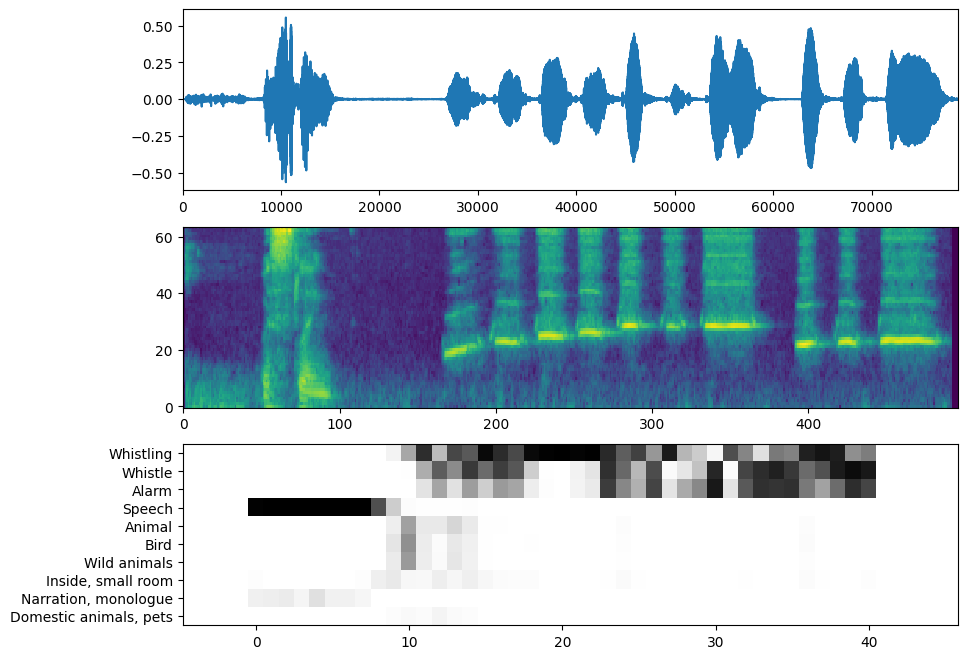

In [8]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
#plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))
